# Title Python for NLP: Multi-label Text Classification with Keras
Link: https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
DATA_DIR = "../../data/raw/"
# INPUT_FILE_NAME = 'cleaned.parquet'
INPUT_FILE_NAME = 'cleaned_squashed.parquet'

In [3]:
df = pd.read_parquet(DATA_DIR + INPUT_FILE_NAME)
# df = df[:200]  # same as df.head(10)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,squash_tags
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"alternative energy,culture,politics,science,cl..."
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"industrial design,alternative energy,invention..."
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"poverty,economics,investment,culture,politics,..."
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"industrial design,invention,engineering,entrep..."
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"industrial design,transportation,invention,des..."


In [4]:
joined_tags = df['squash_tags'].str.cat(sep=',').split(',')
all_tags = pd.Series(joined_tags).str.strip().str.lower()
all_tags = list(dict.fromkeys(all_tags))
try:
    all_tags.remove('')
except:
    pass
print(all_tags)
print(len(all_tags))

['alternative energy', 'culture', 'politics', 'science', 'climate change', 'environment', 'sustainability', 'global issues', 'technology', 'industrial design', 'invention', 'engineering', 'design', 'poverty', 'economics', 'investment', 'policy', 'global development', 'entrepreneur', 'business', 'transportation', 'art', 'biotech', 'oceans', 'genetics', 'dna', 'biology', 'biodiversity', 'ecology', 'computers', 'software', 'interface design', 'music', 'media', 'entertainment', 'performance', 'death', 'architecture', 'cities', 'urban planning', 'collaboration', 'robots', 'education', 'innovation', 'social change', 'disease', 'health', 'health care', 'food', 'africa', 'animals', 'nature', 'cancer', 'creativity', 'love', 'gender', 'relationships', 'cognitive science', 'psychology', 'evolution', 'fish', 'philosophy', 'choice', 'history', 'future', 'storytelling', 'communication', 'community', 'faith', 'religion', 'ted brain trust', 'film', 'activism', 'open-source', 'poetry', 'product design'

In [5]:
def create_one_hot_encode(df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * len(all_tags)
        transcript = [value['clean_transcript_string']]
        indiv_tags = value['squash_tags'].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = all_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = transcript + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['transcript'] + all_tags)
print(len(df))

2386


In [6]:
ted_tags = create_one_hot_encode()
ted_tags

,transcript,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,technology,...,government,big problems,feminism,middle east,journalism,medical research,disability,security,molecular biology,algorithm
0,thank chris truly great honor opportunity come...,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,term invention like tell tale favorite project...,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,public dewey long ago observe constitute discu...,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,want start say houston problem enter second ge...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,want talk background idea car art actually mea...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,imagine walk even discover everybody room look...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2382,pay close attention easy attention pull differ...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2383,happy pic take senior college right dance prac...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2384,sevenyearold grandson sleep hall wake lot morn...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
labels =  ted_tags.iloc[:,1:-1]
labels.head()

,alternative energy,culture,politics,science,climate change,environment,sustainability,global issues,technology,industrial design,...,internet,government,big problems,feminism,middle east,journalism,medical research,disability,security,molecular biology
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X = list(ted_tags['transcript'])
y = ted_tags.iloc[:,1:-1].values
print(labels)

      alternative energy  culture  politics  science  climate change  \
0                      1        1         1        1               1   
1                      1        0         0        0               0   
2                      0        1         1        0               0   
3                      0        0         0        0               0   
4                      0        0         0        0               0   
...                  ...      ...       ...      ...             ...   
2381                   0        0         0        0               0   
2382                   0        0         0        0               0   
2383                   0        0         0        0               0   
2384                   0        0         0        0               0   
2385                   0        0         0        0               0   

      environment  sustainability  global issues  technology  \
0               1               1              1           1   
1      

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
print(X_test[0])
print(y_test)
print(y_test[0])

good morning little boy experience change life fact today moment profoundly affect think art design engineer background fortunate grow family love talented artist world great city dad john ferren die artist passion profession mom rae new york school abstract expressionist contemporary invent american modern art contribute move american zeitgeist modernism th century remarkable thousand year people representational art modern art comparatively speak minute old pervasive important innovation radical idea require new technology fresh think willingness experiment plus resiliency face nearuniversal criticism rejection home art like oxygen necessary life watch paint dad teach art decorative different way communicate idea fact bridge world knowledge insight give rich artistic environment assume compel family business follow path kid genetically program parent crazy artist certainly painter love electronics machine take apart build new one make work fortunately family engineer parent role mode

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(len(all_tags)-1, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# from keras.utils import plot_model
# !pip install pydot
# plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [15]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)




Train on 1526 samples, validate on 382 samples
Epoch 1/20
1526/1526 [==============================] - 8s 6ms/step - loss: 0.5707 - acc: 0.7865 - val_loss: 0.3783 - val_acc: 0.9246
Epoch 2/20
1526/1526 [==============================] - 7s 4ms/step - loss: 0.2572 - acc: 0.9547 - val_loss: 0.1705 - val_acc: 0.9631
Epoch 3/20
1526/1526 [==============================] - 8s 5ms/step - loss: 0.1557 - acc: 0.9632 - val_loss: 0.1484 - val_acc: 0.9631
Epoch 4/20
1526/1526 [==============================] - 9s 6ms/step - loss: 0.1460 - acc: 0.9632 - val_loss: 0.1456 - val_acc: 0.9631
Epoch 5/20
1526/1526 [==============================] - 8s 5ms/step - loss: 0.1444 - acc: 0.9632 - val_loss: 0.1446 - val_acc: 0.9631
Epoch 6/20
1526/1526 [==============================] - 7s 5ms/step - loss: 0.1437 - acc: 0.9632 - val_loss: 0.1443 - val_acc: 0.9631
Epoch 7/20
1526/1526 [==============================] - 8s 5ms/step - loss: 0.1435 - acc: 0.9632 - val_loss: 0.1442 - val_acc: 0.9631
Epoch 8/20
15

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

478/478 [==============================] - 2s 3ms/step
Test Score: 0.1375562268695073
Test Accuracy: 0.9649875371027192


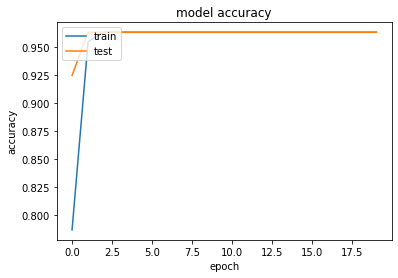

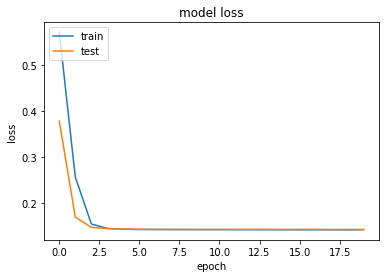

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [18]:
predictions = model.predict(X_test)


In [19]:
print(predictions)

[[0.01477697 0.19980845 0.08443323 ... 0.01400766 0.01513657 0.01413205]
 [0.0147627  0.19973934 0.0845083  ... 0.01400346 0.01513043 0.01412371]
 [0.01476943 0.19975325 0.08441433 ... 0.01400763 0.01512548 0.01412457]
 ...
 [0.01352718 0.19424486 0.06371725 ... 0.01056838 0.01307023 0.01514962]
 [0.01477084 0.19978473 0.08448714 ... 0.01400462 0.01513523 0.01412743]
 [0.01476604 0.19967851 0.08440796 ... 0.01401013 0.01512858 0.01412883]]


In [20]:
print(X_test)

[[1486  701  532 ...   74   20   46]
 [ 451 3496  657 ... 2572   46   46]
 [ 157  257 2366 ... 1546  202   46]
 ...
 [1719  511  380 ...   93  287   46]
 [ 269 2090 2137 ...  352  139   46]
 [ 194    1  493 ...   46   25   46]]


In [21]:
print(predictions[0])
'''
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
 '''
print(predictions[1])


[0.01477697 0.19980845 0.08443323 0.2166242  0.04124171 0.06582162
 0.03212431 0.20223081 0.2785467  0.01244029 0.06102997 0.04011625
 0.16981086 0.02355996 0.06636944 0.01755622 0.02484587 0.02984622
 0.02379054 0.14543033 0.0143387  0.08391255 0.03154552 0.02990958
 0.02189484 0.0190517  0.08118486 0.03038087 0.02098542 0.04785767
 0.01954466 0.01005861 0.03979272 0.03035736 0.11596063 0.03757384
 0.01746053 0.02286077 0.04277667 0.01034251 0.06327417 0.02404159
 0.09362194 0.09500915 0.08450377 0.03021142 0.10489729 0.05780172
 0.01787269 0.0416292  0.04527938 0.04420981 0.02113238 0.06994128
 0.01686996 0.01098993 0.01831964 0.0286274  0.04926836 0.03075233
 0.01344499 0.02625906 0.01897216 0.05273801 0.07863507 0.04677108
 0.07973054 0.05256599 0.01076749 0.02311355 0.02533168 0.02581036
 0.0763222  0.01345325 0.01755577 0.01891577 0.01776034 0.01436231
 0.01175061 0.01882431 0.01533532 0.04878798 0.02078158 0.03807461
 0.0180124  0.01293299 0.05322814 0.01610443 0.0191808  0.0426

In [23]:
sample = predictions[0].tolist()
# print(sample)
final = []
for i in sample:
    if i > 0.2:
        final.append(1)
    else:
        final.append(0)
print(final)
'''
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
 '''    

[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


'\n[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0]\n '

In [24]:
print(y_test[0])

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
